In [1]:
project_name = '06b-anime-dcgan'

In [2]:
# Uncomment and run the appropriate command for your operating system, if required
# No installation is reqiured on Google Colab / Kaggle notebooks

# Linux / Binder / Windows (No GPU)
# !pip install numpy matplotlib torch==1.7.0+cpu torchvision==0.8.1+cpu torchaudio==0.7.0 -f https://download.pytorch.org/whl/torch_stable.html

# Linux / Windows (GPU)
# pip install numpy matplotlib torch==1.7.1+cu110 torchvision==0.8.2+cu110 torchaudio==0.7.2 -f https://download.pytorch.org/whl/torch_stable.html

# MacOS (NO GPU)
# !pip install numpy matplotlib torch torchvision torchaudio

## Downloading and Exploring the Data

We can use the [`opendatasets`](https://github.com/JovianML/opendatasets) library to download the [dataset](https://www.kaggle.com/splcher/animefacedataset) from Kaggle. `opendatasets` uses the [Kaggle Official API](https://github.com/Kaggle/kaggle-api) for downloading datasets from Kaggle.  Follow these steps to find your API credentials:

1. Sign in to  [https://kaggle.com/](https://kaggle.com),  then click on your profile picture on the top right and select "My Account" from the menu.

2. Scroll down to the "API" section and click "Create New API Token". This will download a file `kaggle.json` with the following contents:

```
{"username":"YOUR_KAGGLE_USERNAME","key":"YOUR_KAGGLE_KEY"}
```

3. When you run `opendatsets.download`, you will be asked to enter your username & Kaggle API, which you can get from the file downloaded in step 2.

Note that you need to download the `kaggle.json` file only once. On Google Colab, you can also upload the `kaggle.json` file using the files tab, and the credentials will be read automatically.


In [3]:
!pip install opendatasets --upgrade --quiet

In [10]:
import opendatasets as od

dataset_url = 'https://www.kaggle.com/splcher/animefacedataset'
od.download(dataset_url)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: natasha15pati
Your Kaggle Key: ··········


100%|██████████| 395M/395M [00:05<00:00, 75.7MB/s]


The dataset has a single folder called `images` which contains all 63,000+ images in JPG format.

In [11]:
import os

DATA_DIR = './animefacedataset'
print(os.listdir(DATA_DIR))

['images']


In [12]:
print(os.listdir(DATA_DIR+'/images')[:10])

['5062_2003.jpg', '7439_2004.jpg', '10531_2005.jpg', '36456_2012.jpg', '4333_2003.jpg', '30601_2010.jpg', '13066_2005.jpg', '62223_2019.jpg', '16615_2006.jpg', '54108_2016.jpg']


Let's load this dataset using the `ImageFolder` class from `torchvision`. We will also resize and crop the images to 64x64 px, and normalize the pixel values with a mean & standard deviation of 0.5 for each channel. This will ensure that pixel values are in the range `(-1, 1)`, which is more  convenient for training the discriminator. We will also create a data loader to load the data in batches.

In [13]:
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as T

In [14]:
image_size = 64
batch_size = 128
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

In [15]:
train_ds = ImageFolder(DATA_DIR, transform=T.Compose([
    T.Resize(image_size),
    T.CenterCrop(image_size),
    T.ToTensor(),
    T.Normalize(*stats)]))

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Let's create helper functions to denormalize the image tensors and display some sample images from a training batch.

In [16]:
import torch
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline

In [17]:
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

In [18]:
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break

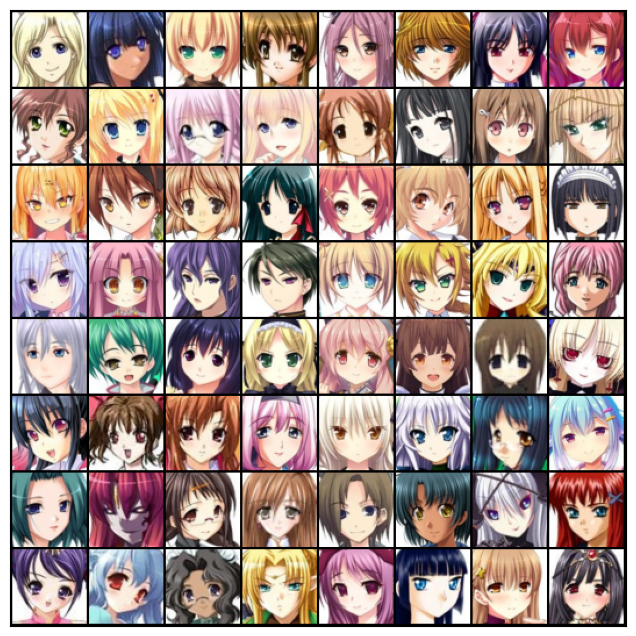

In [19]:
show_batch(train_dl)

In [20]:
!pip install jovian --upgrade --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.6/68.6 kB 2.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [21]:
import jovian

In [22]:
jovian.commit(project=project_name, environment=None)

[jovian] Detected Colab notebook...
[jovian] jovian.commit() is no longer required on Google Colab. If you ran this notebook from Jovian, 
then just save this file in Colab using Ctrl+S/Cmd+S and it will be updated on Jovian. 
Also, you can also delete this cell, it's no longer necessary.


## Using a GPU

To seamlessly use a GPU, if one is available, we define a couple of helper functions (`get_default_device` & `to_device`) and a helper class `DeviceDataLoader` to move our model & data to the GPU, if one is available.

In [23]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

Based on where you're running this notebook, your default device could be a CPU (`torch.device('cpu')`) or a GPU (`torch.device('cuda')`).

In [24]:
device = get_default_device()
device

device(type='cuda')

We can now move our training data loader using `DeviceDataLoader` for automatically transferring batches of data to the GPU (if available).

In [25]:
train_dl = DeviceDataLoader(train_dl, device)

In [26]:
import torch.nn as nn

In [27]:
discriminator = nn.Sequential(
    # in: 3 x 64 x 64

    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 64 x 32 x 32

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 128 x 16 x 16

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 256 x 8 x 8

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 4 x 4

    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
    # out: 1 x 1 x 1

    nn.Flatten(),
    nn.Sigmoid())

In [28]:
discriminator = to_device(discriminator, device)

In [29]:
latent_size = 128

In [30]:
generator = nn.Sequential(
    # in: latent_size x 1 x 1

    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # out: 512 x 4 x 4

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out: 256 x 8 x 8

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # out: 128 x 16 x 16

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # out: 64 x 32 x 32

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
    # out: 3 x 64 x 64
)

torch.Size([128, 3, 64, 64])


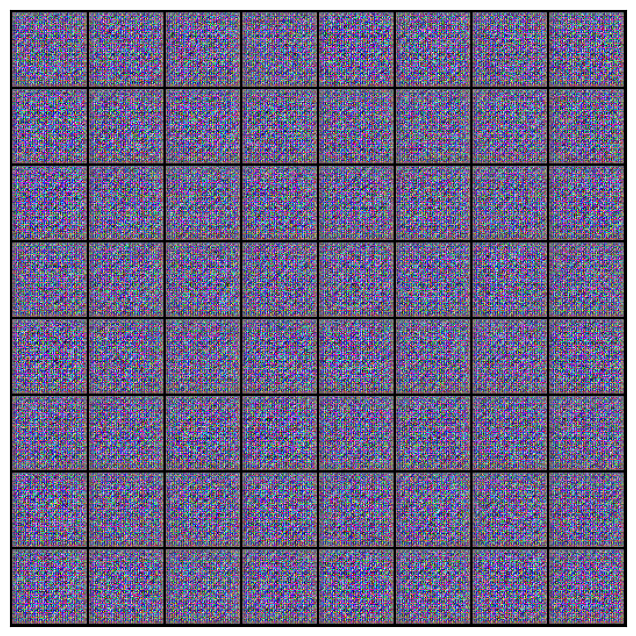

In [31]:
xb = torch.randn(batch_size, latent_size, 1, 1) # random latent tensors
fake_images = generator(xb)
print(fake_images.shape)
show_images(fake_images)

As one might expect, the output from the generator is basically random noise, since we haven't trained it yet.

Let's move the generator to the chosen device.

In [32]:
generator = to_device(generator, device)

In [33]:
def train_discriminator(real_images, opt_d):
    # Clear discriminator gradients
    opt_d.zero_grad()

    # Pass real images through discriminator
    real_preds = discriminator(real_images)
    real_targets = torch.ones(real_images.size(0), 1, device=device)
    real_loss = F.binary_cross_entropy(real_preds, real_targets)
    real_score = torch.mean(real_preds).item()

    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)

    # Pass fake images through discriminator
    fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
    fake_preds = discriminator(fake_images)
    fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
    fake_score = torch.mean(fake_preds).item()

    # Update discriminator weights
    loss = real_loss + fake_loss
    loss.backward()
    opt_d.step()
    return loss.item(), real_score, fake_score

In [34]:
def train_generator(opt_g):
    # Clear generator gradients
    opt_g.zero_grad()

    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)

    # Try to fool the discriminator
    preds = discriminator(fake_images)
    targets = torch.ones(batch_size, 1, device=device)
    loss = F.binary_cross_entropy(preds, targets)

    # Update generator weights
    loss.backward()
    opt_g.step()

    return loss.item()

Let's create a directory where we can save intermediate outputs from the generator to visually inspect the progress of the model. We'll also create a helper function to export the generated images.

In [35]:
from torchvision.utils import save_image

In [36]:
sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok=True)

In [37]:
def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

We'll use a fixed set of input vectors to the generator to see how the individual generated images evolve over time as we train the model. Let's save one set of images before we start training our model.

In [38]:
fixed_latent = torch.randn(64, latent_size, 1, 1, device=device)

Saving generated-images-0000.png


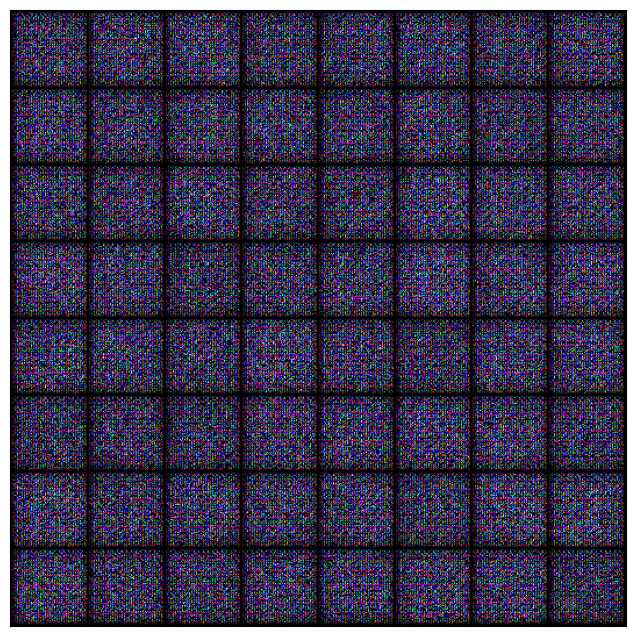

In [39]:
save_samples(0, fixed_latent)

In [40]:
jovian.commit(project=project_name, environment=None)

[jovian] Detected Colab notebook...
[jovian] jovian.commit() is no longer required on Google Colab. If you ran this notebook from Jovian, 
then just save this file in Colab using Ctrl+S/Cmd+S and it will be updated on Jovian. 
Also, you can also delete this cell, it's no longer necessary.


In [41]:
from tqdm.notebook import tqdm
import torch.nn.functional as F

In [42]:
def fit(epochs, lr, start_idx=1):
    torch.cuda.empty_cache()

    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []

    # Create optimizers
    opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))

    for epoch in range(epochs):
        for real_images, _ in tqdm(train_dl):
            # Train discriminator
            loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)
            # Train generator
            loss_g = train_generator(opt_g)

        # Record losses & scores
        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)

        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, loss_g, loss_d, real_score, fake_score))

        # Save generated images
        save_samples(epoch+start_idx, fixed_latent, show=False)

    return losses_g, losses_d, real_scores, fake_scores

We are now ready to train the model. Try different learning rates to see if you can maintain the fine balance between the training the generator and the discriminator.

In [43]:
lr = 0.0002
epochs = 25

In [44]:
jovian.reset()
jovian.log_hyperparams(lr=lr, epochs=epochs)

[jovian] Please enter your API key ( from https://jovian.com/ ):
API KEY: ··········
[jovian] Hyperparams logged.


In [45]:
history = fit(epochs, lr)

  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [1/25], loss_g: 5.5193, loss_d: 0.4772, real_score: 0.8691, fake_score: 0.2485
Saving generated-images-0001.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [2/25], loss_g: 5.6542, loss_d: 0.4570, real_score: 0.8657, fake_score: 0.2403
Saving generated-images-0002.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [3/25], loss_g: 5.7828, loss_d: 0.3634, real_score: 0.9394, fake_score: 0.2255
Saving generated-images-0003.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [4/25], loss_g: 4.8739, loss_d: 0.2545, real_score: 0.8452, fake_score: 0.0661
Saving generated-images-0004.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [5/25], loss_g: 3.5521, loss_d: 0.2584, real_score: 0.8321, fake_score: 0.0257
Saving generated-images-0005.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [6/25], loss_g: 5.7479, loss_d: 0.1496, real_score: 0.9012, fake_score: 0.0285
Saving generated-images-0006.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [7/25], loss_g: 5.9186, loss_d: 0.2107, real_score: 0.8637, fake_score: 0.0092
Saving generated-images-0007.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [8/25], loss_g: 5.2950, loss_d: 0.1136, real_score: 0.9156, fake_score: 0.0069
Saving generated-images-0008.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [9/25], loss_g: 4.6133, loss_d: 0.1515, real_score: 0.9134, fake_score: 0.0373
Saving generated-images-0009.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [10/25], loss_g: 13.0649, loss_d: 0.7099, real_score: 0.9952, fake_score: 0.3989
Saving generated-images-0010.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [11/25], loss_g: 13.6841, loss_d: 0.4384, real_score: 0.9996, fake_score: 0.2513
Saving generated-images-0011.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [12/25], loss_g: 5.6538, loss_d: 0.1373, real_score: 0.9001, fake_score: 0.0187
Saving generated-images-0012.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [13/25], loss_g: 8.1930, loss_d: 0.1232, real_score: 0.9731, fake_score: 0.0840
Saving generated-images-0013.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [14/25], loss_g: 4.1658, loss_d: 0.0814, real_score: 0.9501, fake_score: 0.0102
Saving generated-images-0014.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [15/25], loss_g: 5.6291, loss_d: 0.0422, real_score: 0.9794, fake_score: 0.0154
Saving generated-images-0015.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [16/25], loss_g: 7.8430, loss_d: 0.5391, real_score: 0.6939, fake_score: 0.0000
Saving generated-images-0016.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [17/25], loss_g: 6.9855, loss_d: 0.0480, real_score: 0.9735, fake_score: 0.0124
Saving generated-images-0017.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [18/25], loss_g: 6.9043, loss_d: 0.0956, real_score: 0.9582, fake_score: 0.0390
Saving generated-images-0018.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [19/25], loss_g: 15.7943, loss_d: 0.1627, real_score: 0.9829, fake_score: 0.0960
Saving generated-images-0019.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [20/25], loss_g: 7.5754, loss_d: 0.0673, real_score: 0.9962, fake_score: 0.0588
Saving generated-images-0020.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [21/25], loss_g: 4.1524, loss_d: 0.0428, real_score: 0.9700, fake_score: 0.0090
Saving generated-images-0021.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [22/25], loss_g: 5.8253, loss_d: 0.0340, real_score: 0.9962, fake_score: 0.0289
Saving generated-images-0022.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [23/25], loss_g: 4.6501, loss_d: 0.0437, real_score: 0.9729, fake_score: 0.0114
Saving generated-images-0023.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [24/25], loss_g: 9.7709, loss_d: 0.1827, real_score: 0.9689, fake_score: 0.0810
Saving generated-images-0024.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [25/25], loss_g: 12.6001, loss_d: 0.0153, real_score: 0.9948, fake_score: 0.0096
Saving generated-images-0025.png


In [46]:
losses_g, losses_d, real_scores, fake_scores = history

In [47]:
jovian.log_metrics(loss_g=losses_g[-1],
                   loss_d=losses_d[-1],
                   real_score=real_scores[-1],
                   fake_score=fake_scores[-1])

[jovian] Metrics logged.


Now that we have trained the models, we can save checkpoints.

In [48]:
# Save the model checkpoints
torch.save(generator.state_dict(), 'G.pth')
torch.save(discriminator.state_dict(), 'D.pth')

Here's how the generated images look, after the 1st, 5th and 10th epochs of training.

In [49]:
from IPython.display import Image

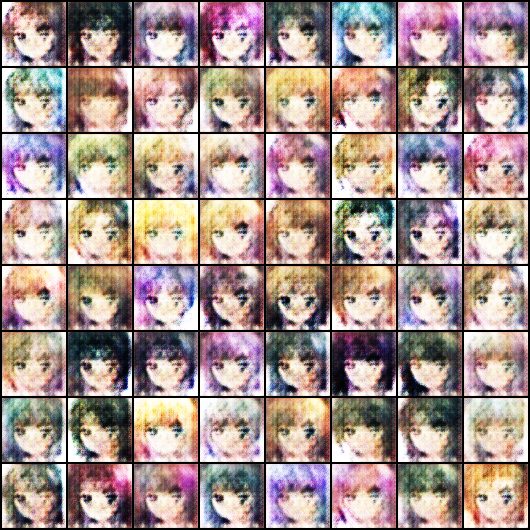

In [50]:
Image('./generated/generated-images-0001.png')

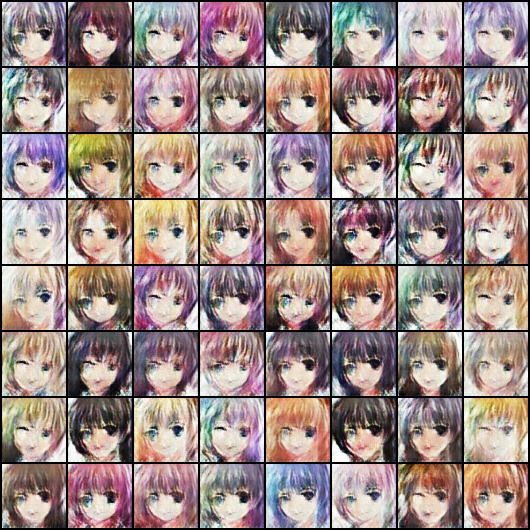

In [51]:
Image('./generated/generated-images-0005.png')

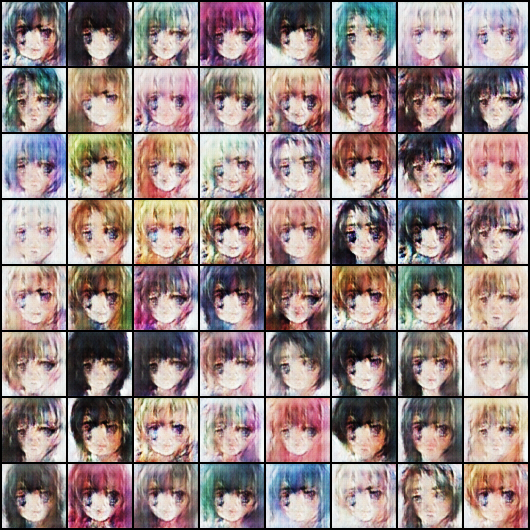

In [52]:
Image('./generated/generated-images-0010.png')

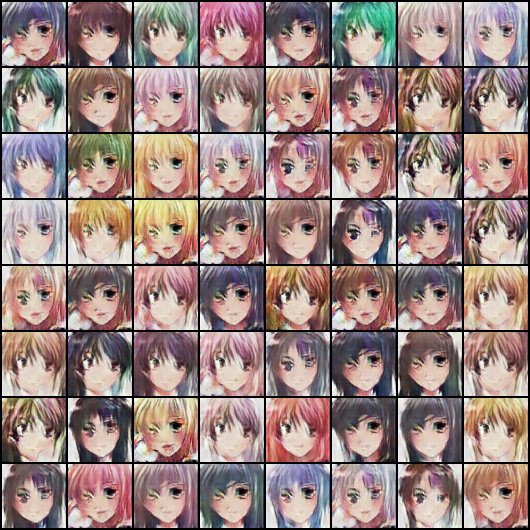

In [53]:
Image('./generated/generated-images-0020.png')

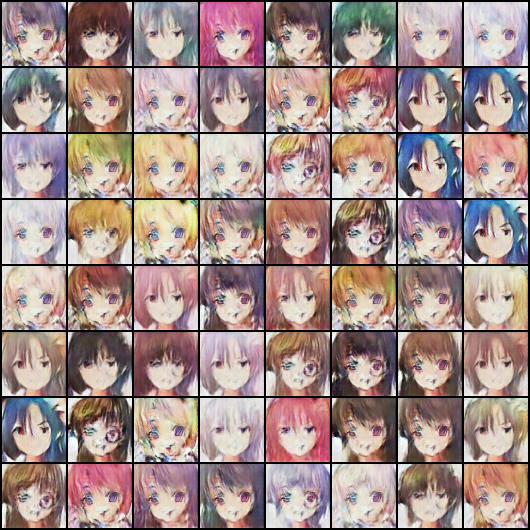

In [54]:
Image('./generated/generated-images-0025.png')

We can visualize the training process by combining the sample images generated after each epoch into a video using OpenCV.

In [55]:
import cv2
import os

vid_fname = 'gans_training.avi'

files = [os.path.join(sample_dir, f) for f in os.listdir(sample_dir) if 'generated' in f]
files.sort()

out = cv2.VideoWriter(vid_fname,cv2.VideoWriter_fourcc(*'MP4V'), 1, (530,530))
[out.write(cv2.imread(fname)) for fname in files]
out.release()

Here's what it looks like:

![]()


We can also visualize how the loss changes over time. Visualizing
losses is quite useful for debugging the training process. For GANs, we expect the generator's loss to reduce over time, without the discriminator's loss getting too high.



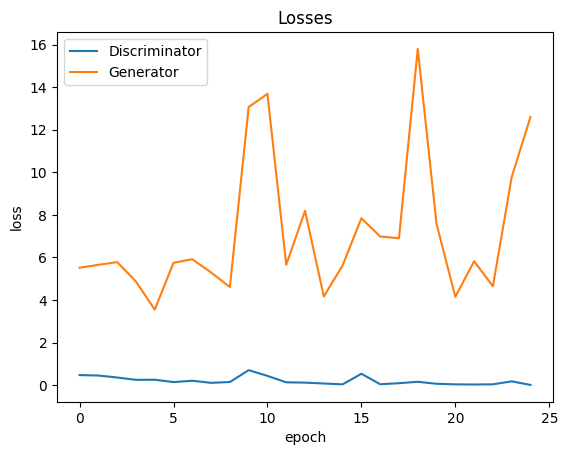

In [56]:
plt.plot(losses_d, '-')
plt.plot(losses_g, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

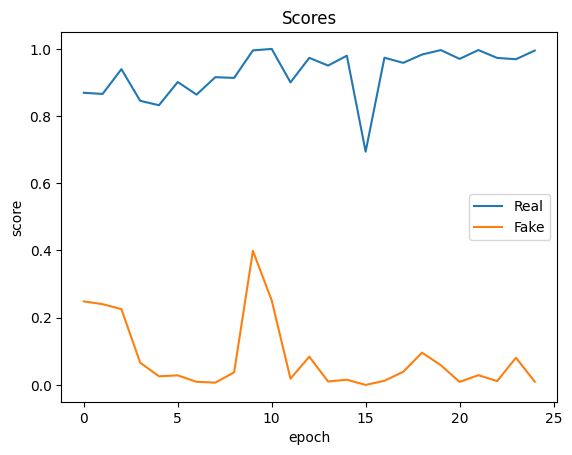

In [57]:
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real', 'Fake'])
plt.title('Scores');

## Save and Commit

We can upload the full snapshot of this experiment to Jovian:
- Jupyter notebook
- Hyperparameters & metrics
- Models weights
- Training video

In [58]:
import jovian

In [59]:
jovian.commit(project=project_name,
              outputs=['G.pth', 'D.pth', 'gans_training.avi'],
              environment=None)

[jovian] Detected Colab notebook...
[jovian] jovian.commit() is no longer required on Google Colab. If you ran this notebook from Jovian, 
then just save this file in Colab using Ctrl+S/Cmd+S and it will be updated on Jovian. 
Also, you can also delete this cell, it's no longer necessary.
